In [1]:
import os 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# from torchvision.transforms import ToTensor
from torch.utils.data import random_split,DataLoader
import matplotlib.pyplot as plt 
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
from sklearn.metrics import classification_report


In [2]:
data_transforms= transforms.Compose([
     transforms.Resize(112),
     transforms.CenterCrop((100, 100)),
     transforms.RandomCrop((80, 80)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.|5, 0.5, 0.5)),
     ])


In [3]:
Image_data=ImageFolder('cell_images/',data_transforms)

In [4]:
# lets checks some of our images 
list1=os.listdir('cell_images/Parasitized')
list2=os.listdir('cell_images/Uninfected')
print(len(list1))
print(len(list2))
print(len(list1)+len(list2))

13780
13780
27560


The dataset is balanced so its easy to work with 

torch.Size([3, 80, 80])


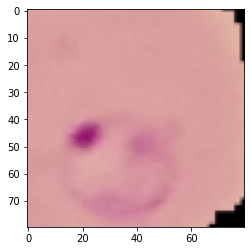

In [5]:
image,labels=Image_data[0]
print(image.shape)
plt.imshow(image.permute(1,2,0))

In [6]:
# splitting the datasets into training and validation data 
val_size = 3000
train_size = len(Image_data) - val_size

train_ds, val_ds = random_split(Image_data, [train_size, val_size])
len(train_ds), len(val_ds)

(24558, 3000)

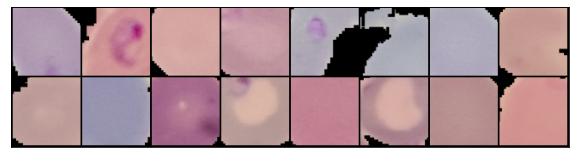

In [8]:
def make_grid_func(data_loader):
    for image,labels in data_loader:
        fig,axes=plt.subplots(figsize=(10,10))
        axes.set_xticks([]);axes.set_yticks([])
        axes.imshow(make_grid(image,8).permute(1,2,0))
        break
        
make_grid_func(train_dl)
        

In [7]:
train_dl=DataLoader(train_ds,batch_size=16,pin_memory=True,shuffle=True,num_workers=0)
val_dl=DataLoader(val_ds,batch_size=16,pin_memory=True,shuffle=False,num_workers=0)

In [10]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    else :
        return data.to(device,non_blocking=True)

class DeviceDataLoaders():
    def __init__(self,data,device):
        self.data=data
        self.device=device
    
    def __iter__(self):
        for x in self.data:
            yield to_device(x,self.device)
            
    def __len__(self):
        return len(self.data)

In [11]:
device=get_device()
device

device(type='cuda')

In [12]:
train_dl_gpu=DeviceDataLoaders(train_dl,device)
val_dl_gpu=DeviceDataLoaders(val_dl,device)


In [13]:
# defining our model 
model=torchvision.models.resnet152(pretrained=True)
model

        

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
for param in model.fc.parameters():
    param.required_grad = False

In [15]:
num_ftrs = model.fc.in_features
out = 2     #( pred class)
model.fc = nn.Linear(num_ftrs, out)

model = model.to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
loss_funtion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),1e-4)

In [16]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
#Training the model 
training_loss=[]
training_correct=[]
val_loss=[]
val_correct=[]
epochs=10
for epoch in range(epochs):
    val_corr=0
    train_corr=0
    
    for b,(image,label) in enumerate(tqdm(train_dl_gpu)):
        b+=1
        y_val=model(image)
        train_loss=loss_funtion(y_val,label)
        _,preds=torch.max(y_val,dim=1)
        batch_corr=(preds==label).sum()
        train_corr+=batch_corr
        
        # computing the loss ,calculating the gradients
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        
        for b1,(images,labels) in enumerate(tqdm(val_dl_gpu)):
            b1+=1
            y_val2=model(images)
            val_loss1=loss_funtion(y_val2,labels)
            _,preds2=torch.max(y_val2,dim=1)
            batch_corr1=(preds2==labels).sum()
            val_corr+=batch_corr1
    
    training_correct.append(train_corr)
    val_correct.append(val_corr)
    val_loss.append(val_loss1)
    training_loss.append(train_loss)
    
    print(f'epoch:[{epoch}] train_loss:{train_loss:.4f} train_acc:{train_corr.item()/245.58:.4f} val_loss:{val_loss1:.4f} val_acc:{val_corr.item()/30:.4f}')
        

  0%|                                                                                         | 0/1535 [00:00<?, ?it/s]

epoch:[0] train_loss:0.2421 train_acc:88.8712 val_loss:0.4450 val_acc:91.4667


  0%|                                                                                 | 1/1535 [00:00<04:07,  6.19it/s]

epoch:[1] train_loss:0.2587 train_acc:90.6751 val_loss:0.8684 val_acc:90.6667


  0%|                                                                                 | 1/1535 [00:00<05:00,  5.10it/s]

epoch:[2] train_loss:0.4898 train_acc:91.3022 val_loss:0.2603 val_acc:91.9333


  0%|                                                                                 | 1/1535 [00:00<04:26,  5.76it/s]

epoch:[3] train_loss:0.0749 train_acc:91.6565 val_loss:0.6026 val_acc:92.7000


  0%|                                                                                 | 1/1535 [00:00<04:19,  5.92it/s]

epoch:[4] train_loss:0.3945 train_acc:91.8967 val_loss:0.2335 val_acc:92.9333


  0%|                                                                                         | 0/1535 [00:00<?, ?it/s]

epoch:[5] train_loss:0.0617 train_acc:92.1940 val_loss:0.0848 val_acc:92.8000


  0%|                                                                                 | 1/1535 [00:00<04:48,  5.31it/s]

epoch:[6] train_loss:0.4311 train_acc:92.4790 val_loss:0.3807 val_acc:92.3333


  0%|                                                                                 | 1/1535 [00:00<04:15,  6.00it/s]

epoch:[7] train_loss:0.0992 train_acc:92.4750 val_loss:0.2365 val_acc:93.0000


  0%|                                                                                 | 1/1535 [00:00<04:23,  5.81it/s]

epoch:[8] train_loss:0.0908 train_acc:92.6704 val_loss:0.9324 val_acc:92.9000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.59it/s]

epoch:[9] train_loss:0.2715 train_acc:92.8903 val_loss:0.6728 val_acc:92.7000


In [44]:
for b,(image,label) in enumerate(train_dl_gpu):
        y_val=model(image)
        break

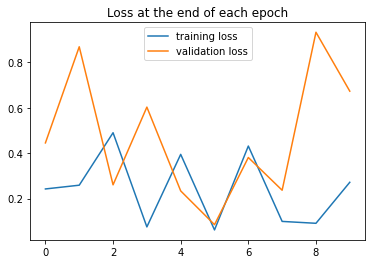

In [19]:
train_loss=[t.cpu().item() for t in training_loss]
val_loss=[t.cpu().item() for t in val_loss]
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

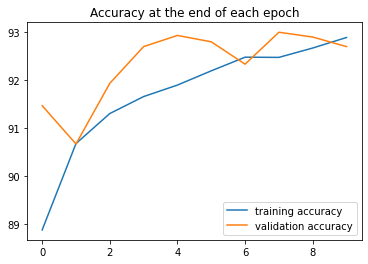

In [21]:
plt.plot([t.cpu()/245.58 for t in training_correct], label='training accuracy')
plt.plot([t.cpu()/30 for t in val_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [22]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(val_dl):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.28it/s]


In [23]:
y_pred=[]
y_true=[]
for i in y_pred_list:
    for j in i:
        y_pred.append(j)
for k in y_true_list:
    for t in k:
        y_true.append(t)

In [25]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1539
           1       0.90      0.95      0.92      1461

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [29]:
torch.save(model.state_dict(), 'malaria_resnet152.pt')

In [16]:
model.load_state_dict(torch.load('malaria_resnet152.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 